In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(20061, 28)
(20061, 2)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, -0.031441960856, -0.0136477514252, -0.0127038601305,
       -0.00244656498529, 0.00516659590702, 0.014237910934,
       -0.0715826028263, -0.398971193528, 0.000248611213881,
       -0.399555781735, 0.0179192922017, -0.000367993487606,
       0.402828296044, -0.0267053264964, 0.000249471553281,
       0.0463155300908, 0.397264323636, -0.000133312153753, True, False,
       False, True, 0.0, 0.0, 0.0], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, 21] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(10035,)

## Predict CoM -> x

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, -0.031441960856, -0.0136477514252, -0.0127038601305,
       -0.00244656498529, 0.00516659590702, 0.014237910934,
       -0.0715826028263, -0.398971193528, 0.000248611213881,
       -0.399555781735, 0.0179192922017, -0.000367993487606,
       0.402828296044, -0.0267053264964, 0.000249471553281,
       0.0463155300908, 0.397264323636, -0.000133312153753, True, False,
       False, True, 0.0, 0.0, 0.0], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.009566533575338099, -0.0029288409990329], dtype=object)

### Linear Regression

In [16]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9595331999696659
RMSE:  0.008002421511681554
The lowest error is:  3.1517707350381396e-06
The highest error is:  0.05492988109819154
The avg. error is:  0.005589568421320619


In [17]:
model_fl_com_x.coef_

array([[-0.00118848,  0.00476276, -0.00575461,  0.13961594,  0.01091284,
        -0.00196097, -0.18913551,  0.15876759, -0.08021554,  0.19394194,
        -0.08546236,  0.30269309, -0.0932808 ,  0.16249433]])

In [18]:
model_fl_com_x.intercept_

array([0.00825741])

In [19]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[0.01455544]])

Text(0, 0.5, 'Predictions')

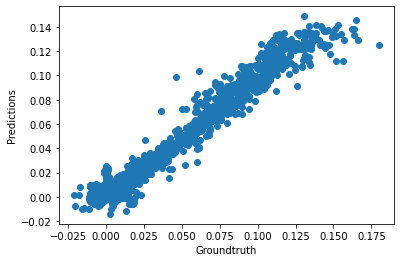

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [21]:
#%store model_fl_com_x

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [23]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [25]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # motion command
               X_motion_CoM_FL_RR[:, -3:], # Current motion command
               X_motion_CoM_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9063039630906405
RMSE:  0.007654549961684635
The lowest error is:  2.337362882189834e-06
The highest error is:  0.0620439381647809
The avg. error is:  0.005505845067957039


In [26]:
model_fl_com_y.coef_

array([[ 0.00176666,  0.00383346, -0.00223724,  0.00324382,  0.15506061,
        -0.00033925, -0.01565562, -0.18706853,  0.06250759, -0.07208814,
        -0.03400149,  0.03670775,  0.10393649, -0.09758938]])

In [27]:
model_fl_com_y.intercept_

array([-0.00280065])

Text(0, 0.5, 'Predictions')

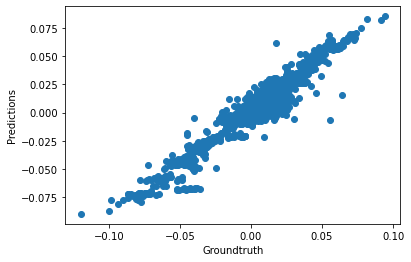

In [28]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [29]:
#%store model_fl_com_y

In [28]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")